Main program
Load a stereo wav file with:
*   on the left the microphone track
*   on the right the piezo pickup track

Change the filename in the 5th line of the code to match your file name

filename='XXXX.wav'

Output files name are like
*   IR_XXXX_44k_2048_Std.wav
*   IR_XXXX_44k_2048_Std_Bld.wav
*   IR_XXXX_44k_2048_M.wav

44k stands for 44.1KHz sampling rate. It is the same as your recording.

2048 stands for the IR length (Cheap pedal only use 1024 or 512 pts from the 2048pts) 

Std stands for Standard

Std_Bld stands for Standard with 50% raw pickup / 50% IR blend

M stands for Modified process (usually clearer than the standard)

In [ ]:
import soundfile as sf
import math
import numpy as np
from scipy import signal
filename='LmicRpic.wav'
NbF=2048 # Size of output IR
#========================================================================#
def oct_spectrum2(s,fs):
  b=3
  dbref=1
  weightFlag=1
  plotflag=0

  #s = s(:)';
  L = len(s)
  G = 10**(3/10) # % octave ratio, base 10
  fr = 1000 # % reference frequency
  x = np.arange(1,43) # % band number
  Gstar = np.power(G,(x - 30)/b)
  fm = np.multiply(Gstar,fr) # midband frequency
  f2 = np.multiply(np.power(G,1/(2*b)),fm) # upper bandedge freq.
  x=np.delete(x, np.where(f2 < 20), axis=0) # doit être mis avant la modif de f2
  x=np.delete(x, np.where(f2 > fs/2), axis=0) # doit être mis avant la modif de f2
  fm=np.delete(fm, np.where(f2 < 20), axis=0) # doit être mis avant la modif de f2
  fm=np.delete(fm, np.where(f2 > fs/2), axis=0) # doit être mis avant la modif de f2
  f2=np.delete(f2, np.where(f2 < 20), axis=0) # modif de f2
  f2=np.delete(f2, np.where(f2 > fs/2), axis=0)
  f1 = np.multiply(np.power(G,-1/(2*b)),fm) # lower bandedge freq.
  Br = np.divide((f2 - f1),fm) # normalized reference bandwidth
  #sfilt = np.zeros(len(x),L) # initialization of third-octave filtered signals
  rms2=np.sqrt(1/len(s)*sum(np.power(s,2)))
  overall_lev = 10*np.log10(np.power(np.divide(rms2,dbref),2)) # overall level fonction rms
  #fm
  S=np.zeros(len(x))

  #filtering
  for k in range(0,len(x)):
    B,A = signal.butter(2,[f1[k], f2[k]],btype='bandpass',fs=fs)
    #[B,A]= bp_synth(2,(f1(k)+f2(k))/2,abs(f1(k)-f2(k)),fs);
    sfilt = signal.lfilter(B,A,s)
    rms2b=np.sqrt(1/len(sfilt)*sum(sfilt**2))  
    # octave spectrum
    S[k] = 10*np.log10((rms2b/dbref)**2) #; % band levels in dB or dBA
    
  #  weighted overall level
  overall_levA = 10*np.log10(np.sum(np.power(10,S/10)));

  return S, fm, overall_lev, overall_levA, f1, f2
#========================================================================#
data, fs = sf.read(filename)
Nb0=data.shape
Nb=Nb0[0] # Sample file size
mic=data[:,0] # Mic sample
pic=data[:,1] # Pic sample
FIR1=np.zeros(NbF,dtype = 'complex_')
Nbuff=fs; # Buffer size
Nbmax=math.floor(Nb/Nbuff)-10
alice=np.zeros((NbF,Nbmax),dtype = 'complex_')
#print(Nbmax)
for n in range(Nbmax):
  #q=n
  i=3*fs+n*Nbuff
  FIR=np.divide(np.fft.fft(mic[i:i+Nbuff-1],NbF),np.fft.fft(pic[i:i+Nbuff-1],NbF))
  IR=np.real(np.fft.ifft(FIR,NbF))
  IR=IR/np.amax(np.absolute(IR))
  if any(np.isinf(FIR))==True or any(np.isnan(FIR))==True:
    IR=np.zeros(Nbuff)
    IR[0]=1
    FIR=np.fft.fft(IR,NbF)
    print('NaN or Inf')
  alice[0:NbF,n]=FIR;
  FIR1=FIR1+FIR;
ALICE=np.zeros(NbF,dtype = 'complex_')
bob=np.zeros((2,Nbmax),dtype = 'complex_')
for i in range(NbF): #Frequency browse
  a=alice[i,:]
  A=a[np.absolute(np.absolute(a)-np.mean(a))<2*np.std(a)] # On ne garde que les echantillons compris dans 2 ecarts types
  if any(np.isnan(A)) or any(np.isinf(A)):
    A=1
    print('NaN or Inf detected')
  else:
    A=np.mean(A)
    #print('Mean taken')
  ALICE[i]=A
dnuX=fs/NbF
nuX=np.arange(-NbF/2,NbF/2)*dnuX
nn=range(int(NbF/2)+1,int(NbF))
nn2=np.arange(0,int(2*NbF))
window = (.42-.5*np.cos(2*np.pi*nn2/(2*NbF-1))+.08*np.cos(4*np.pi*nn2/(2*NbF-1)))
blackmanwin=window[NbF-1:len(window)-1] #temporal blackman
ir2=np.fft.ifft(ALICE)
ir2=np.multiply(ir2,blackmanwin)
ir2=ir2/np.amax(np.absolute(ir2))*0.95
IR2=np.real(ir2) # raw IR generated
# Reference sample test at 10s and 20s
nn3=np.arange(10*fs+1,20*fs)
MS=mic[nn3]
PS=np.convolve(pic[nn3],IR2,'same')
p, cf, overall_lev, overall_levA, f1, f2=oct_spectrum2(MS/np.amax(np.absolute(MS)),fs)
p2, cf2, overall_lev, overall_levA, f1, f2=oct_spectrum2(PS/np.amax(np.absolute(PS)),fs)
pp=[p+100,p2+100]
g0=p-p2 # SB-SB2 gain difference
#dgain=np.zeros(len(cf))

IRX=np.zeros(NbF)
IRX[0]=1
IR1=IR2
for i in range(0,len(f1)): # Browse each frequency of the octave spectrum
  g=g0[i] # dgain terme correctif GEQ fit
  fc=cf[i]
  # IIR coefficient calculation
  g=10**(g/20);

  B,A = signal.butter(2,[f1[i], f2[i]],btype='bandpass',fs=fs)
  sfilt = signal.lfilter(B,A,IRX)*(g-1)
  IRX=IRX+sfilt # sert de référence pour affichage si besoin
  sfilt1 = signal.lfilter(B,A,IR1)*(g-1)
  IR1=IR1+sfilt1 

IR1=IR1/np.amax(np.absolute(IR1))*0.95;
fmt=str(fs/1000)
IR1filename='IR_'+filename[0:len(filename)-4]+'_'+fmt[0:2]+'k_'+str(len(IR1))+'_M'+'.wav'
print("saving to " + IR1filename + ", Please wait...")
sf.write(IR1filename, IR1, fs, 'PCM_24')
IR2filename='IR_'+filename[0:len(filename)-4]+'_'+fmt[0:2]+'k_'+str(len(IR1))+'_Std.wav'
print("saving to " + IR2filename + ", Please wait...")
sf.write(IR2filename, IR2, fs, 'PCM_24')

IRX=np.zeros(NbF)
IRX[0]=1
IR3=(IRX+IR2)/2
IR3filename='IR_'+filename[0:len(filename)-4]+'_'+fmt[0:2]+'k_'+str(len(IR3))+'_Std_Bld.wav'
print("saving to " + IR3filename + ", Please wait...")
sf.write(IR3filename, IR3, fs, 'PCM_24')


saving to IR_LmicRpic_44k_2048_M.wav, Please wait...
saving to IR_LmicRpic_44k_2048_Std.wav, Please wait...
saving to IR_LmicRpic_44k_2048_Std_Bld.wav, Please wait...


IR Display, run those to display the IRs and their spectrum

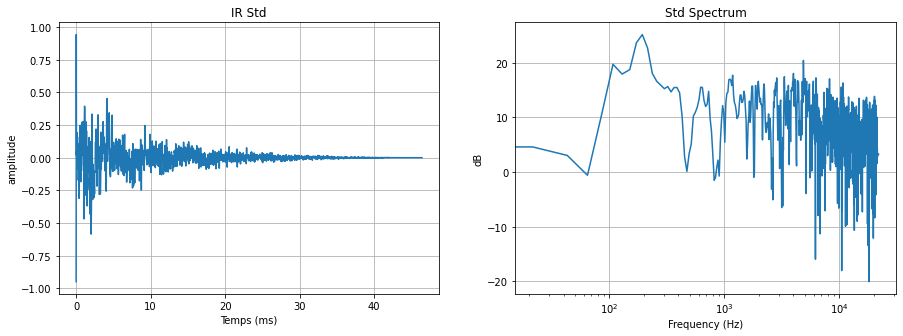

In [ ]:
from matplotlib import pyplot as plt
IRX=IR2
t=np.arange(0,len(IRX))/fs
FIRX=np.fft.fft(IRX,NbF)
freq = np.fft.fftfreq(len(t), t[1] - t[0]) #Pas besoin de fftshift avec ça

f, axs = plt.subplots(1, 2,figsize=(15,5))  
axs[0].plot(t*1000, IRX)   
axs[0].set_title("IR Std" )  
axs[0].set_xlabel("Temps (ms)")  
axs[0].set_ylabel("amplitude")  
axs[0].grid()  
SdB=20*np.log10(np.absolute(FIRX))
axs[1].plot(freq[0:int(NbF/2)], SdB[0:int(NbF/2)])
axs[1].set_title("Std Spectrum" )  
axs[1].set_xlabel("Frequency (Hz)")  
axs[1].set_ylabel("dB")  
axs[1].grid()  
axs[1].set_xscale('log')


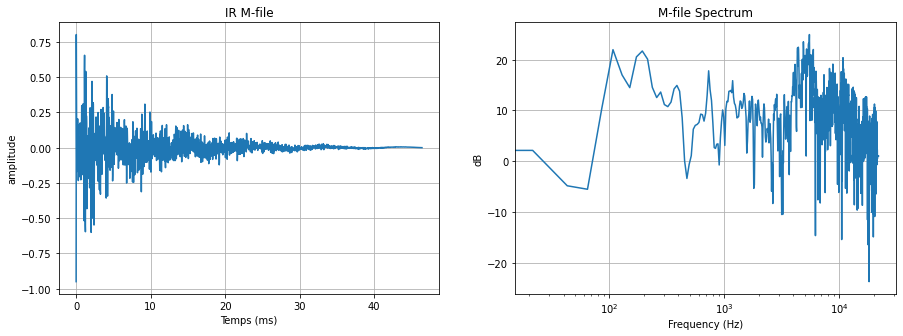

In [ ]:
from matplotlib import pyplot as plt
IRX=IR1
t=np.arange(0,len(IRX))/fs
FIRX=np.fft.fft(IRX,NbF)
freq = np.fft.fftfreq(len(t), t[1] - t[0]) #Pas besoin de fftshift avec ça

f, axs = plt.subplots(1, 2,figsize=(15,5))  
axs[0].plot(t*1000, IRX)   
axs[0].set_title("IR M-file" )  
axs[0].set_xlabel("Temps (ms)")  
axs[0].set_ylabel("amplitude")  
axs[0].grid()  
SdB=20*np.log10(np.absolute(FIRX))
axs[1].plot(freq[0:int(NbF/2)], SdB[0:int(NbF/2)])
axs[1].set_title("M-file Spectrum" )  
axs[1].set_xlabel("Frequency (Hz)")  
axs[1].set_ylabel("dB")  
axs[1].grid()  
axs[1].set_xscale('log')